In [1]:
import pandas as pd
from medangel.data import preprocessing
from medangel.models import model_builder
from medangel.features import feature_creation
import numpy as np
from tsfresh.utilities.dataframe_functions import roll_time_series
import tsfresh

settings =  tsfresh.feature_extraction.ComprehensiveFCParameters()

features_directory = r'C:\Users\AliHa\Desktop\Masters Project\medangel\data\preprocessed\rolling_data_features.h5'
features = pd.read_hdf(features_directory, key='f')
df = preprocessing.load_relevant_data()
devices = df["device_id"].value_counts()
y_shifted = pd.read_hdf(r'C:\Users\AliHa\Desktop\Masters Project\medangel\data\preprocessed\rolling_labels_shifted_device_59497_20.h5', key='y')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Python\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-83470f7dce5d>", line 12, in <module>
    features = pd.read_hdf(features_directory, key='f')
  File "C:\Python\lib\site-packages\pandas\io\pytables.py", line 407, in read_hdf
    return store.select(key, auto_close=auto_close, **kwargs)
  File "C:\Python\lib\site-packages\pandas\io\pytables.py", line 782, in select
    return it.get_result()
  File "C:\Python\lib\site-packages\pandas\io\pytables.py", line 1639, in get_result
    results = self.func(self.start, self.stop, where)
  File "C:\Python\lib\site-packages\pandas\io\pytables.py", line 766, in func
    return s.read(start=_start, stop=_stop, where=_where, columns=columns)
  File "C:\Python\lib\site-packages\pandas\io\pytables.py", line 3206, in read
    "block{idx}_values".format(idx=i), start=_start, stop=_stop
  File "C:\Py

KeyboardInterrupt: 

In [ ]:
y_shifted = y_shifted.dropna()
for device in devices.index:
    if device == 59497:
        print("passing 59497")
        continue
    
    temp_y_shifted = pd.read_hdf(r'C:\Users\AliHa\Desktop\Masters Project\medangel\data\preprocessed\rolling_labels_shifted_device_' + str(device) + '_20.h5', key='y')
    temp_y_shifted = temp_y_shifted.dropna()
    y_shifted = y_shifted.append(temp_y_shifted)

In [ ]:
y_shifted=y_shifted.loc[features.index]

In [4]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from tsfresh.transformers import FeatureSelector
rf_clf = Pipeline([
    ('sampler',RandomUnderSampler(random_state=42)),
    ('augmenter',FeatureSelector()),
    ('classifier',RandomForestClassifier(random_state=42, n_jobs=2)),
])


In [5]:
from sklearn.model_selection import cross_val_predict

cv_predict_result = cross_val_predict(rf_clf, features, y_shifted["label_shifted"].to_numpy())

In [6]:
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(y_shifted["label_shifted"].to_numpy(),cv_predict_result)

0.7885428806803993

In [7]:
from lightgbm import LGBMClassifier

lgbm_clf = Pipeline([
    ('sampler',RandomUnderSampler(random_state=42)),
    ('augmenter',FeatureSelector()),
    ('classifier',LGBMClassifier(random_state=42, n_jobs=-1)),
])

In [8]:
import re
import numpy as np
array_features = features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
array_features = np.array(array_features)
cv_predict_result_lgbm = cross_val_predict(lgbm_clf, array_features, y_shifted["label_shifted"].to_numpy())
matthews_corrcoef(y_shifted["label_shifted"].to_numpy(),cv_predict_result_lgbm)

0.7953332322076491

In [9]:
rf_clf.fit(features, y_shifted["label_shifted"].to_numpy())

Pipeline(steps=[('sampler', RandomUnderSampler(random_state=42)),
                ('augmenter', FeatureSelector()),
                ('classifier',
                 RandomForestClassifier(n_jobs=2, random_state=42))])

In [10]:
rf_clf.named_steps

{'sampler': RandomUnderSampler(random_state=42),
 'augmenter': FeatureSelector(),
 'classifier': RandomForestClassifier(n_jobs=2, random_state=42)}

In [11]:
len(rf_clf.named_steps['augmenter'].relevant_features)

528

In [12]:
importance = pd.Series(rf_clf.named_steps['classifier'].feature_importances_,index =rf_clf.named_steps['augmenter'].relevant_features ).sort_values(ascending = False)

In [13]:
importance

temperature__minimum                                           0.037061
temperature__quantile__q_0.1                                   0.026577
temperature__quantile__q_0.7                                   0.026516
temperature__quantile__q_0.9                                   0.025737
temperature__c3__lag_3                                         0.023328
                                                                 ...   
temperature__symmetry_looking__r_0.55                          0.000000
temperature__large_standard_deviation__r_0.6000000000000001    0.000000
temperature__large_standard_deviation__r_0.75                  0.000000
temperature__large_standard_deviation__r_0.55                  0.000000
temperature__large_standard_deviation__r_0.9500000000000001    0.000000
Length: 528, dtype: float64

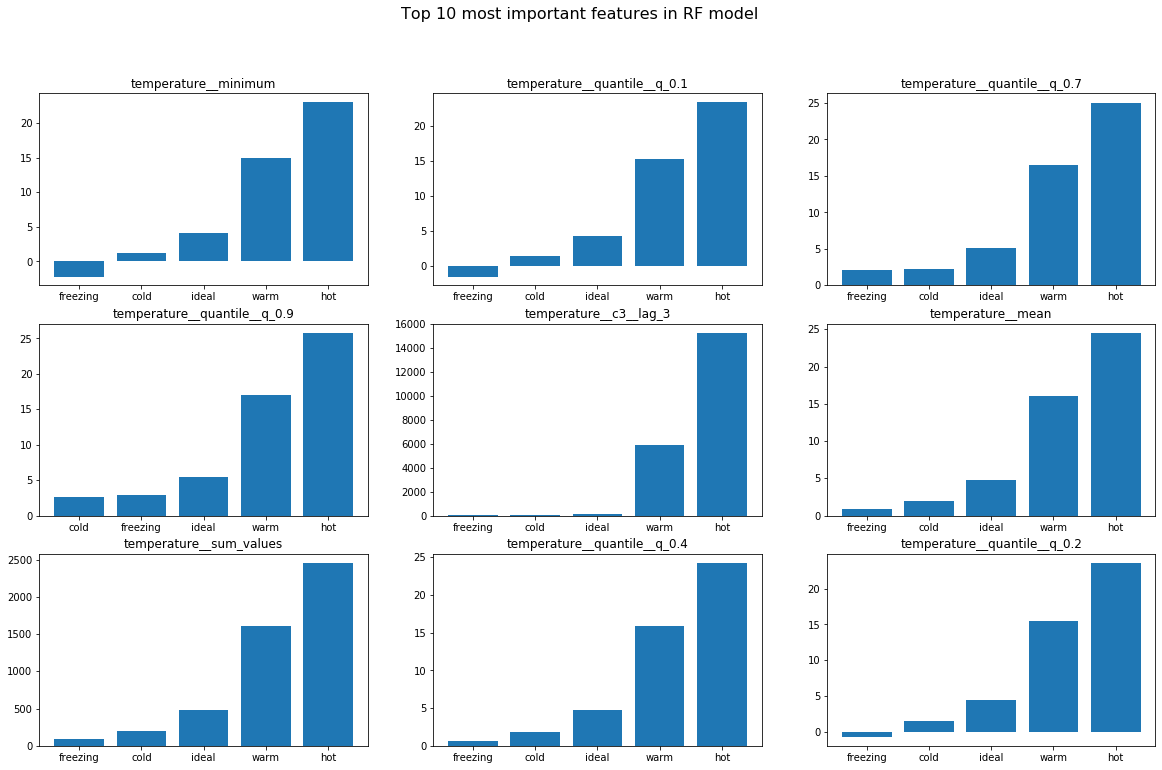

In [14]:
import matplotlib.pyplot as plt
xy_matrix = features
xy_matrix["label"] = y_shifted["label_shifted"]
#xy_matrix.groupby("label")[importance.index[0]].mean().plot(kind='bar', title = importance.index[0])
fig,axs = plt.subplots(3,3)
fig.set_size_inches(20,12)
fig.suptitle("Top 10 most important features in RF model",fontsize=16)
imp = 0
for i in range(3):
    for j in range(3):
        axs[i,j].bar(xy_matrix.groupby("label")[importance.index[imp]].mean().sort_values().index,
                     xy_matrix.groupby("label")[importance.index[imp]].mean().sort_values().values)
        axs[i,j].set_title(importance.index[imp])
        imp +=1